In [1]:
import tensorflow as tf
from src.dataset import dataset_tf, validation_tf
from src.audio import to_mfccs_dataset, to_spectrogram_dataset
from src.model import get_seq_model, get_conv_model, callbacks, get_conv_model_mini
from src.plots import plot_history, plot_mfccs, plot_spectrograms
LEARNING_RATE = 0.0001

0.90 - For proving that using pre-trained model works better

In [2]:
train_ds, val_ds, label_names = dataset_tf("./dataset/sbcm", 0.30, 16)

Found 688 files belonging to 2 classes.
Using 482 files for training.
Using 206 files for validation.
label names: ['noqueen' 'queen']
(TensorSpec(shape=(None, 4000, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
Example audio shape: (16, 4000)
Example label shape: (16,)


2024-03-25 00:19:06.743769: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2024-03-25 00:19:06.743791: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-03-25 00:19:06.743798: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-03-25 00:19:06.743834: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-25 00:19:06.743850: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


513 44100
Label: noqueen
Waveform shape: (4000,)
MFCCs shape: (12, 16)
Spectrogram shape: (118, 129, 1)
513 44100
Label: queen
Waveform shape: (4000,)
MFCCs shape: (12, 16)
Spectrogram shape: (118, 129, 1)


In [3]:
train_mfccs_ds = to_mfccs_dataset(train_ds)
val_mfccs_ds = to_mfccs_dataset(val_ds)
train_spectrogram_ds = to_spectrogram_dataset(train_ds)
val_spectrogram_ds = to_spectrogram_dataset(val_ds)

513 44100
513 44100


# Train raw models

## Raw - MFCCs

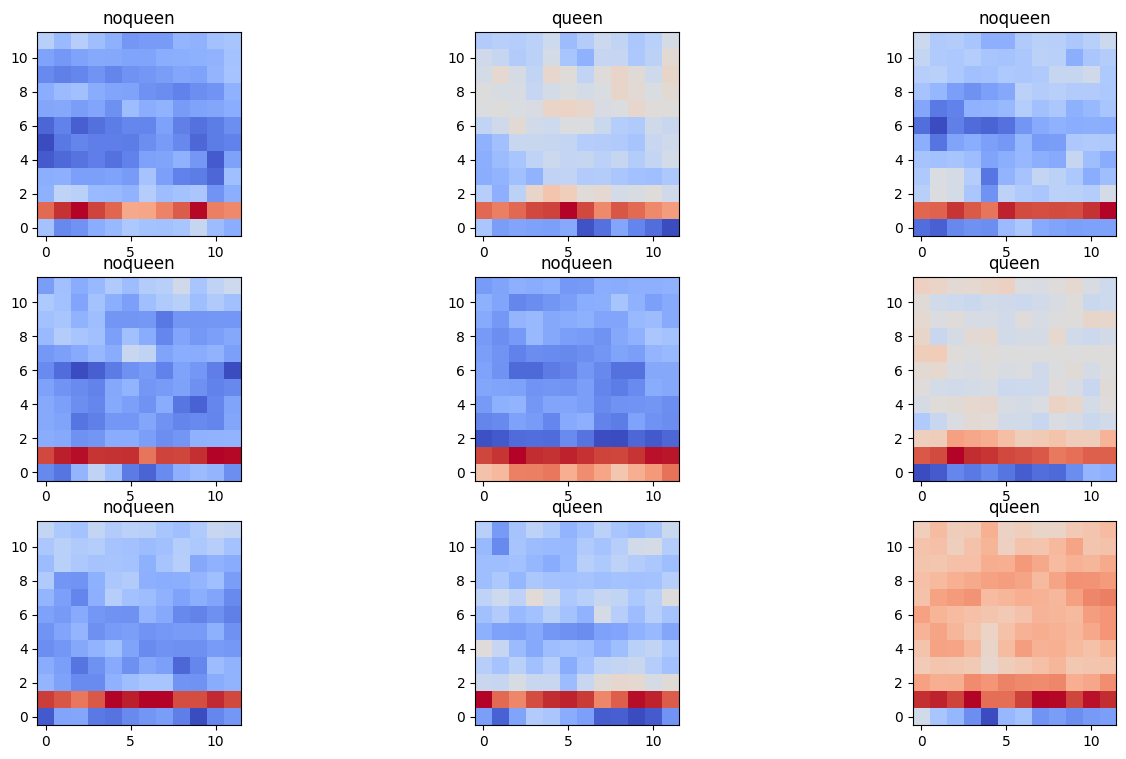

In [4]:
for example_mfccs, example_mfccs_labels in train_mfccs_ds.take(1):
  break

plot_mfccs(example_mfccs, example_mfccs_labels, label_names)

In [5]:
train_mfccs_ds = train_mfccs_ds.map(lambda x, y: (tf.expand_dims(x, -1), y))
val_mfccs_ds = val_mfccs_ds.map(lambda x, y: (tf.expand_dims(x, -1), y))

for example_mfccs, example_mfccs_labels in train_mfccs_ds.take(1):
  break
input_shape = example_mfccs.shape[1:]
input_shape

TensorShape([12, 12, 1])

In [6]:
train_mfccs_ds = train_mfccs_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_mfccs_ds = val_mfccs_ds.cache().prefetch(tf.data.AUTOTUNE)

### [Reinf:Raw] [MFCCs] Sequential Model

2024-03-25 00:19:08.252370: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


Epoch 1/20


2024-03-25 00:19:09.040451: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


31/31 [==============================] - 3s 73ms/step - loss: 0.6754 - accuracy: 0.5705 - val_loss: 0.5623 - val_accuracy: 0.7670
Epoch 2/20
31/31 [==============================] - 0s 12ms/step - loss: 0.5287 - accuracy: 0.7531 - val_loss: 0.5179 - val_accuracy: 0.7864
Epoch 3/20
31/31 [==============================] - 0s 12ms/step - loss: 0.4796 - accuracy: 0.7656 - val_loss: 0.4915 - val_accuracy: 0.8107
Epoch 4/20
31/31 [==============================] - 0s 13ms/step - loss: 0.4479 - accuracy: 0.8174 - val_loss: 0.4805 - val_accuracy: 0.8398
Epoch 5/20
31/31 [==============================] - 0s 13ms/step - loss: 0.4139 - accuracy: 0.8257 - val_loss: 0.4712 - val_accuracy: 0.8058
Epoch 6/20
31/31 [==============================] - 0s 13ms/step - loss: 0.3899 - accuracy: 0.8527 - val_loss: 0.4667 - val_accuracy: 0.8447
Epoch 7/20
31/31 [==============================] - 0s 12ms/step - loss: 0.3687 - accuracy: 0.8444 - val_loss: 0.4653 - val_accuracy: 0.8301
Epoch 8/20
31/31 [======

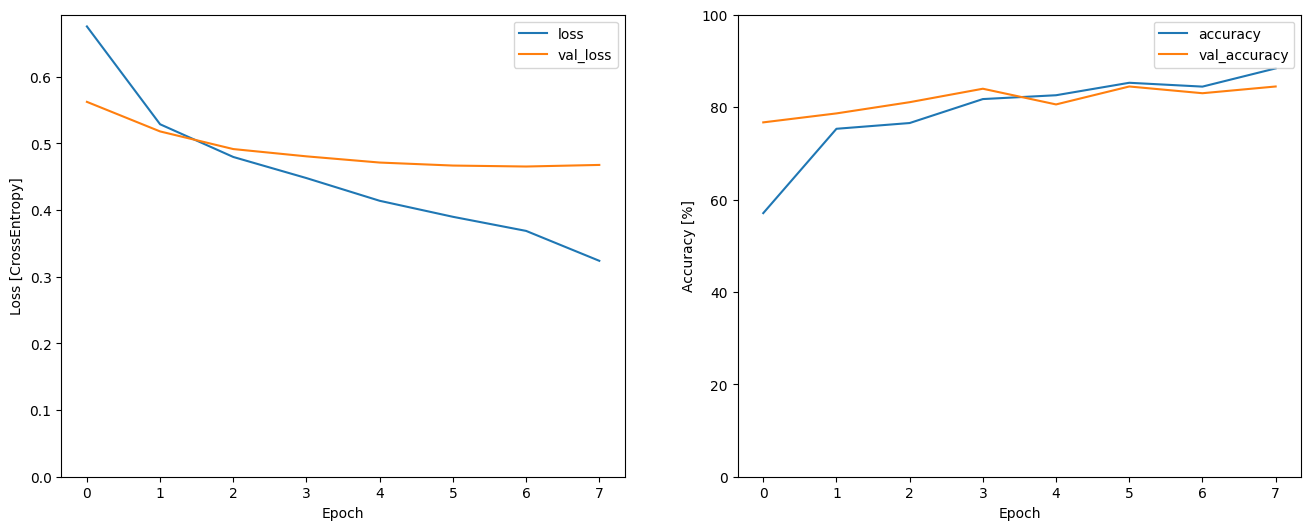

In [7]:
model_mfcc_seq = get_seq_model(input_shape, len(label_names), train_mfccs_ds)
model_mfcc_seq.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
history_mfcc_seq = model_mfcc_seq.fit(
    train_mfccs_ds,
    validation_data=val_mfccs_ds,
    epochs=20,
    callbacks=callbacks
)
plot_history(history_mfcc_seq)

### [Reinf:Raw] [MFCCs] Convolutional Model (mini)

Epoch 1/20
31/31 [==============================] - 2s 41ms/step - loss: 0.6953 - accuracy: 0.5104 - val_loss: 0.6908 - val_accuracy: 0.5097
Epoch 2/20
31/31 [==============================] - 0s 6ms/step - loss: 0.6793 - accuracy: 0.5394 - val_loss: 0.6791 - val_accuracy: 0.5194
Epoch 3/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6656 - accuracy: 0.5705 - val_loss: 0.6637 - val_accuracy: 0.5777
Epoch 4/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6525 - accuracy: 0.5934 - val_loss: 0.6482 - val_accuracy: 0.6311
Epoch 5/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6383 - accuracy: 0.6286 - val_loss: 0.6328 - val_accuracy: 0.6650
Epoch 6/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6267 - accuracy: 0.6411 - val_loss: 0.6239 - val_accuracy: 0.6845
Epoch 7/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6153 - accuracy: 0.6452 - val_loss: 0.6064 - val_accuracy: 0.7136
Epoch 8/20
31/31 [=

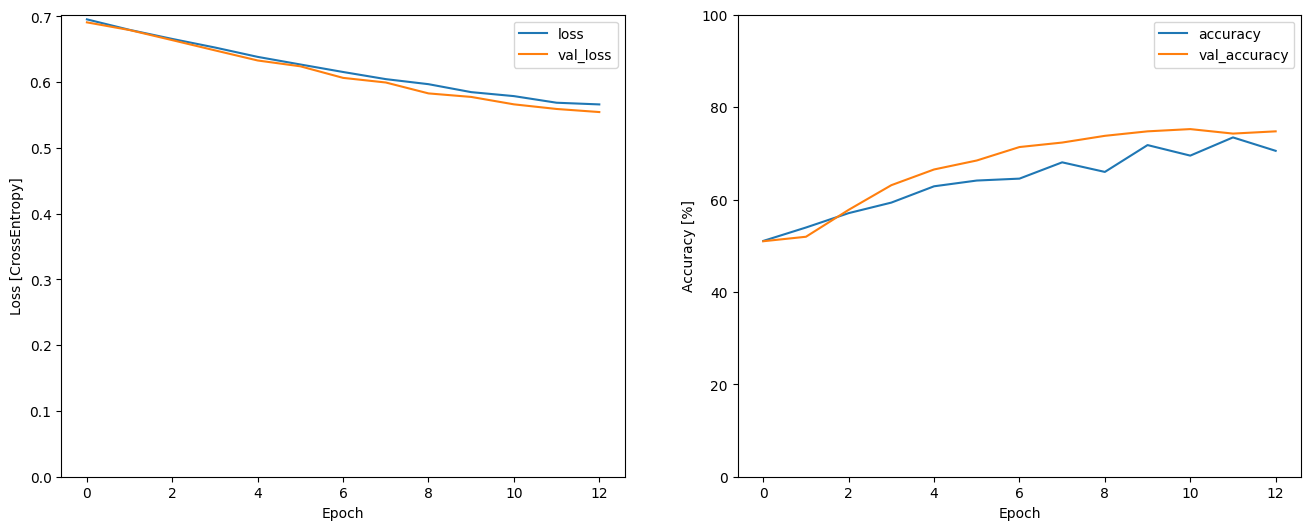

In [8]:
model_mfcc_conv = get_conv_model_mini(input_shape, len(label_names))
model_mfcc_conv.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=LEARNING_RATE), 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)
history_mfcc_conv = model_mfcc_conv.fit(
    train_mfccs_ds, 
    validation_data=val_mfccs_ds, 
    epochs=20,
    callbacks=callbacks
)
plot_history(history_mfcc_conv)

## Raw - Spectrograms

(118, 129, 1)


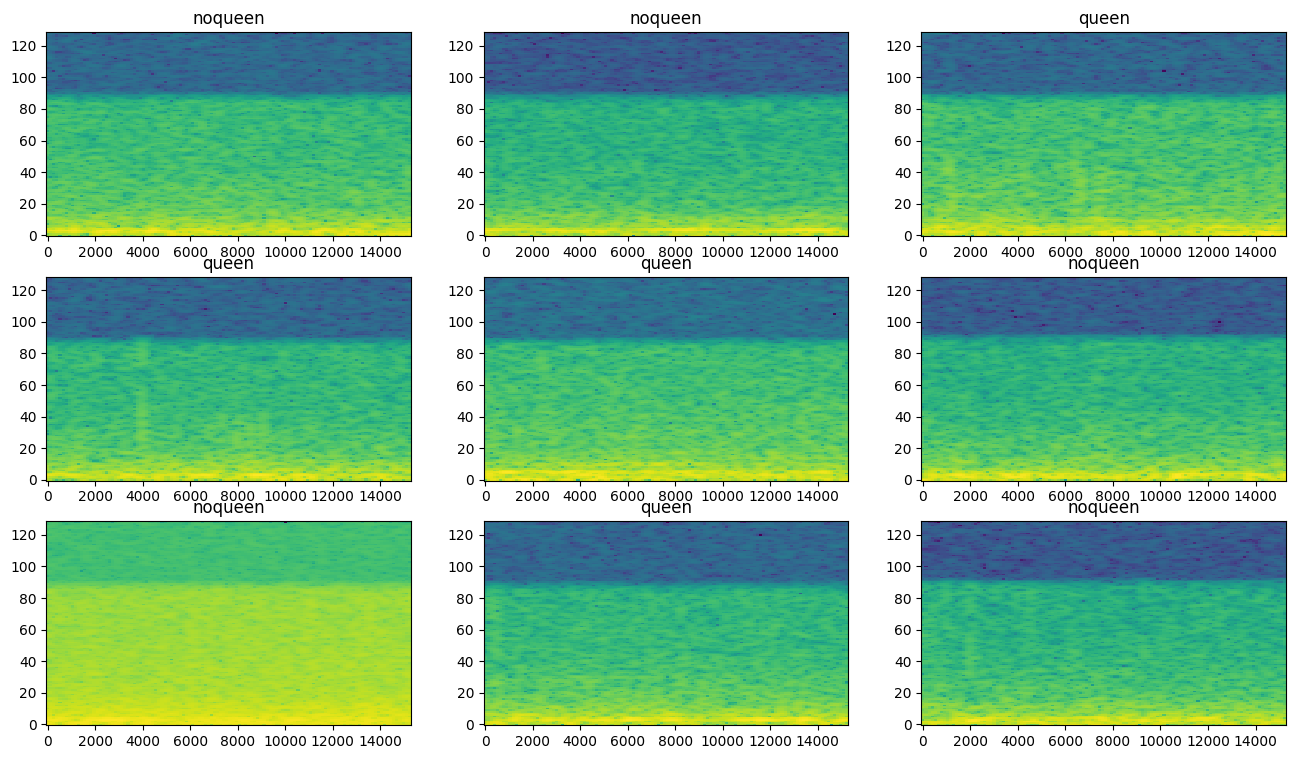

In [9]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break
# (TensorShape([118, 129, 1])
input_shape = example_spectrograms.shape[1:]
print(input_shape)
plot_spectrograms(example_spectrograms, example_spect_labels, label_names)

In [10]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

### [Reinf:Raw] [Spec] Sequential model

Epoch 1/20
31/31 [==============================] - 1s 20ms/step - loss: 0.6988 - accuracy: 0.5021 - val_loss: 0.6800 - val_accuracy: 0.6505
Epoch 2/20
31/31 [==============================] - 0s 12ms/step - loss: 0.6702 - accuracy: 0.5934 - val_loss: 0.6718 - val_accuracy: 0.6359
Epoch 3/20
31/31 [==============================] - 0s 13ms/step - loss: 0.6471 - accuracy: 0.6494 - val_loss: 0.6602 - val_accuracy: 0.6505
Epoch 4/20
31/31 [==============================] - 0s 13ms/step - loss: 0.6327 - accuracy: 0.6307 - val_loss: 0.6510 - val_accuracy: 0.6456
Epoch 5/20
31/31 [==============================] - 0s 11ms/step - loss: 0.6057 - accuracy: 0.6888 - val_loss: 0.6338 - val_accuracy: 0.6845
Epoch 6/20
31/31 [==============================] - 0s 11ms/step - loss: 0.5881 - accuracy: 0.7095 - val_loss: 0.6206 - val_accuracy: 0.7184
Epoch 7/20
31/31 [==============================] - 0s 11ms/step - loss: 0.5632 - accuracy: 0.7137 - val_loss: 0.6088 - val_accuracy: 0.7136
Epoch 8/20
31

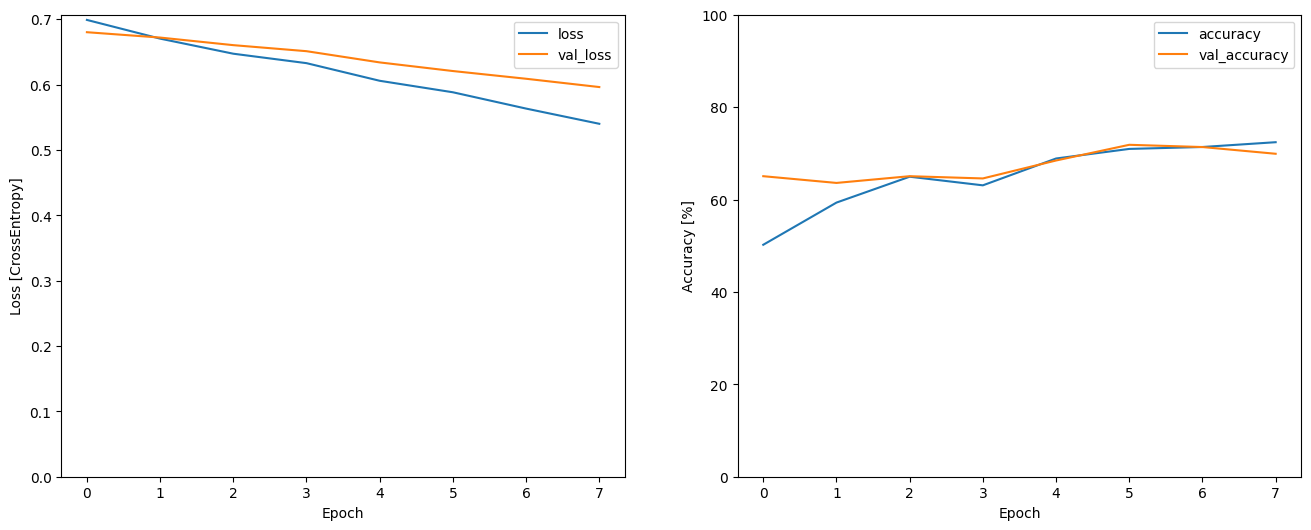

In [11]:
model_spec_seq = get_seq_model(input_shape, len(label_names), train_spectrogram_ds)
model_spec_seq.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
history_spec_seq = model_spec_seq.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=20,
    callbacks=callbacks
)
plot_history(history_spec_seq)

### [Reinf:Raw] [Spec] Convolutional model

Epoch 1/20
31/31 [==============================] - 1s 30ms/step - loss: 0.6977 - accuracy: 0.5436 - val_loss: 0.6626 - val_accuracy: 0.5922
Epoch 2/20
31/31 [==============================] - 0s 13ms/step - loss: 0.6404 - accuracy: 0.6037 - val_loss: 0.6433 - val_accuracy: 0.6942
Epoch 3/20
31/31 [==============================] - 0s 9ms/step - loss: 0.6101 - accuracy: 0.6743 - val_loss: 0.6522 - val_accuracy: 0.5194
Epoch 4/20
31/31 [==============================] - 0s 11ms/step - loss: 0.5923 - accuracy: 0.6473 - val_loss: 0.6446 - val_accuracy: 0.7330
Epoch 5/20
31/31 [==============================] - 0s 11ms/step - loss: 0.5811 - accuracy: 0.6950 - val_loss: 0.6156 - val_accuracy: 0.6165
Epoch 6/20
31/31 [==============================] - 0s 11ms/step - loss: 0.5463 - accuracy: 0.7075 - val_loss: 0.6374 - val_accuracy: 0.5485


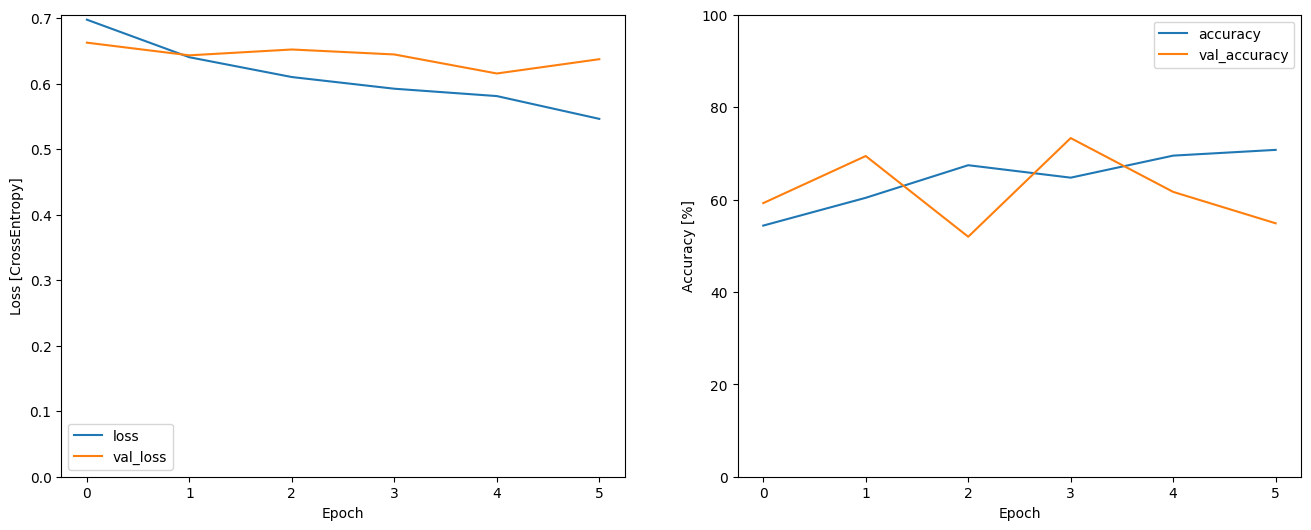

In [12]:
model_spec_conv = get_conv_model(input_shape, len(label_names))
model_spec_conv.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=LEARNING_RATE), 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)
history_spec_conv = model_spec_conv.fit(
    train_spectrogram_ds, 
    validation_data=val_spectrogram_ds, 
    epochs=20,
    callbacks=callbacks
)
plot_history(history_spec_conv)

# Pre-trained models

In [13]:
trained_model_mfcc_seq = tf.keras.models.load_model("models/mfcc_seq.h5")
trained_model_mfcc_conv = tf.keras.models.load_model("models/mfcc_conv_mini.h5")
trained_model_spec_seq = tf.keras.models.load_model("models/spec_seq.h5")
trained_model_spec_conv = tf.keras.models.load_model("models/spec_conv.h5")

In [14]:
results = trained_model_mfcc_seq.evaluate(val_mfccs_ds)
print(f"MFCC Seq: {results}")
results = trained_model_mfcc_conv.evaluate(val_mfccs_ds)
print(f"MFCC Conv: {results}")
results = trained_model_spec_seq.evaluate(val_spectrogram_ds)
print(f"Spec Seq: {results}")
results = trained_model_spec_conv.evaluate(val_spectrogram_ds)
print(f"Spec Conv: {results}")

13/13 [==============================] - 0s 8ms/step - loss: 1.0447 - accuracy: 0.5000
MFCC Seq: [1.0447497367858887, 0.5]
13/13 [==============================] - 0s 6ms/step - loss: 1.0277 - accuracy: 0.4320
MFCC Conv: [1.0276525020599365, 0.4320388436317444]
13/13 [==============================] - 0s 9ms/step - loss: 3.6280 - accuracy: 0.4612
Spec Seq: [3.6280226707458496, 0.46116504073143005]
13/13 [==============================] - 0s 7ms/step - loss: 11.2130 - accuracy: 0.4757
Spec Conv: [11.212950706481934, 0.4757281541824341]


### [Reinf] [MFCCs] Sequential model

Epoch 1/20
31/31 [==============================] - 1s 14ms/step - loss: 0.8196 - accuracy: 0.5768 - val_loss: 0.7083 - val_accuracy: 0.5583
Epoch 2/20
31/31 [==============================] - 0s 12ms/step - loss: 0.5873 - accuracy: 0.6929 - val_loss: 0.5993 - val_accuracy: 0.6990
Epoch 3/20
31/31 [==============================] - 0s 11ms/step - loss: 0.5275 - accuracy: 0.7365 - val_loss: 0.6090 - val_accuracy: 0.6553
Epoch 4/20
31/31 [==============================] - 0s 11ms/step - loss: 0.5049 - accuracy: 0.7490 - val_loss: 0.5570 - val_accuracy: 0.7427
Epoch 5/20
31/31 [==============================] - 0s 11ms/step - loss: 0.4717 - accuracy: 0.7718 - val_loss: 0.5366 - val_accuracy: 0.7816
Epoch 6/20
31/31 [==============================] - 0s 12ms/step - loss: 0.4525 - accuracy: 0.7884 - val_loss: 0.5436 - val_accuracy: 0.7816
Epoch 7/20
31/31 [==============================] - 0s 11ms/step - loss: 0.4422 - accuracy: 0.7967 - val_loss: 0.5310 - val_accuracy: 0.7913
Epoch 8/20
31

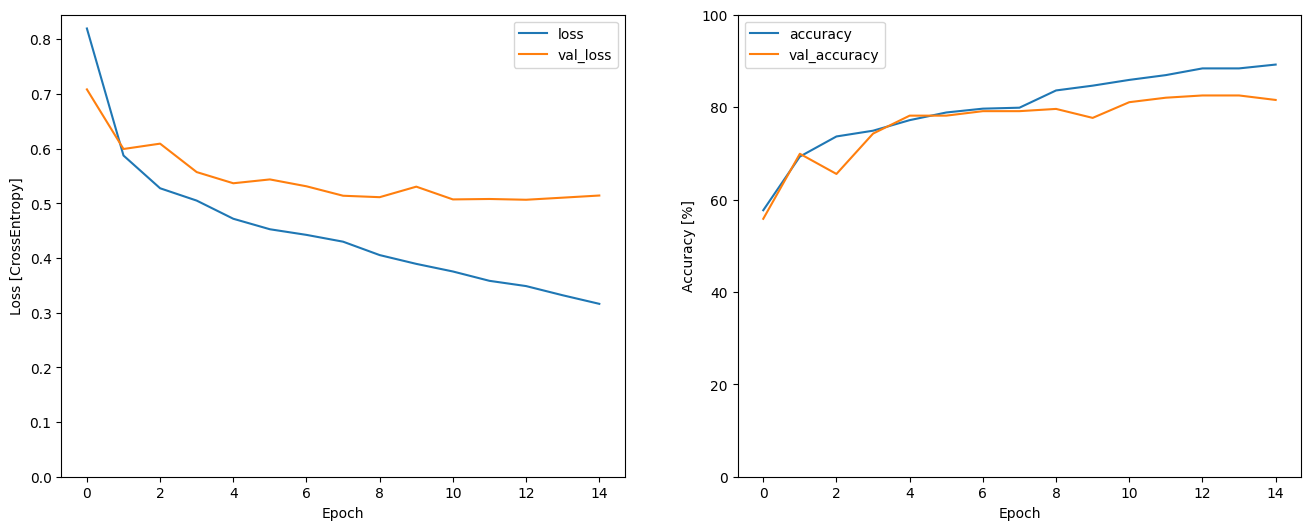

In [15]:
trained_history_mfcc_seq = trained_model_mfcc_seq.fit(
    train_mfccs_ds, 
    validation_data=val_mfccs_ds, 
    epochs=20,
    callbacks=callbacks
)
plot_history(trained_history_mfcc_seq)

### [Reinf] [MFCCs] Convolutional model (mini)

Epoch 1/20
31/31 [==============================] - 1s 18ms/step - loss: 0.7716 - accuracy: 0.5145 - val_loss: 0.7242 - val_accuracy: 0.4951
Epoch 2/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6480 - accuracy: 0.6203 - val_loss: 0.6358 - val_accuracy: 0.6796
Epoch 3/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6169 - accuracy: 0.6618 - val_loss: 0.6191 - val_accuracy: 0.6893
Epoch 4/20
31/31 [==============================] - 0s 5ms/step - loss: 0.5967 - accuracy: 0.6826 - val_loss: 0.6017 - val_accuracy: 0.7233
Epoch 5/20
31/31 [==============================] - 0s 6ms/step - loss: 0.5836 - accuracy: 0.7054 - val_loss: 0.6642 - val_accuracy: 0.5583
Epoch 6/20
31/31 [==============================] - 0s 5ms/step - loss: 0.5891 - accuracy: 0.6701 - val_loss: 0.5868 - val_accuracy: 0.7184


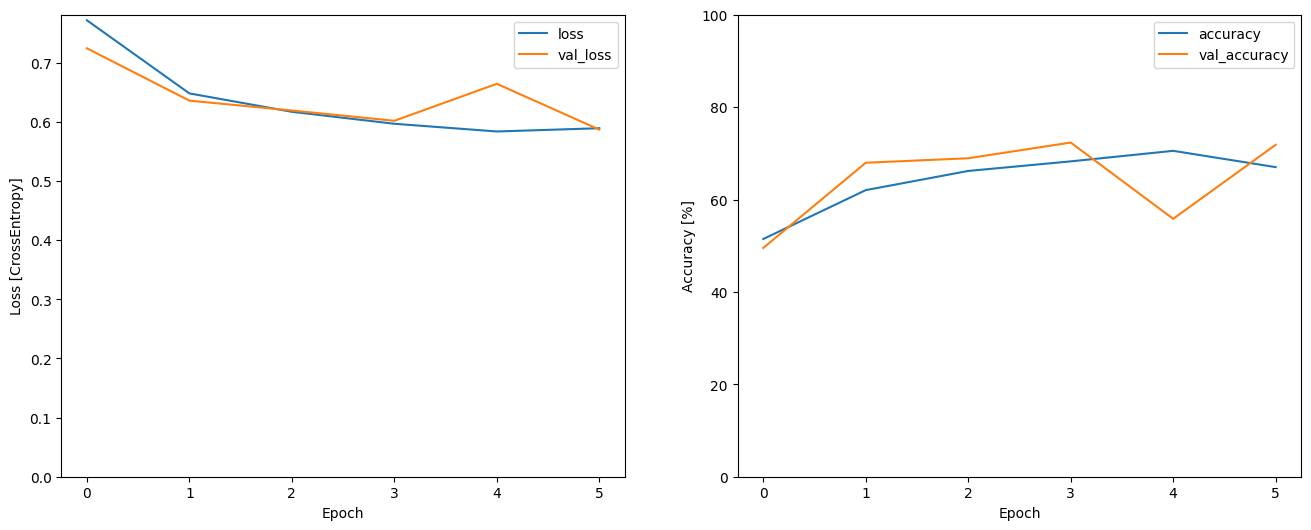

In [16]:
trained_history_mfcc_conv = trained_model_mfcc_conv.fit(
    train_mfccs_ds, 
    validation_data=val_mfccs_ds, 
    epochs=20,
    callbacks=callbacks
)
plot_history(trained_history_mfcc_conv)

### [Reinf] [Spec] Sequential model

Epoch 1/20
31/31 [==============================] - 1s 14ms/step - loss: 1.5634 - accuracy: 0.5477 - val_loss: 0.8773 - val_accuracy: 0.6117
Epoch 2/20
31/31 [==============================] - 0s 11ms/step - loss: 0.7294 - accuracy: 0.5975 - val_loss: 0.6633 - val_accuracy: 0.6553
Epoch 3/20
31/31 [==============================] - 0s 11ms/step - loss: 0.6098 - accuracy: 0.6515 - val_loss: 0.6427 - val_accuracy: 0.6505
Epoch 4/20
31/31 [==============================] - 0s 11ms/step - loss: 0.5859 - accuracy: 0.7054 - val_loss: 0.6443 - val_accuracy: 0.6845
Epoch 5/20
31/31 [==============================] - 0s 11ms/step - loss: 0.5475 - accuracy: 0.7178 - val_loss: 0.6216 - val_accuracy: 0.6650
Epoch 6/20
31/31 [==============================] - 0s 12ms/step - loss: 0.5280 - accuracy: 0.7344 - val_loss: 0.6541 - val_accuracy: 0.7039
Epoch 7/20
31/31 [==============================] - 0s 11ms/step - loss: 0.5109 - accuracy: 0.7407 - val_loss: 0.6275 - val_accuracy: 0.7087


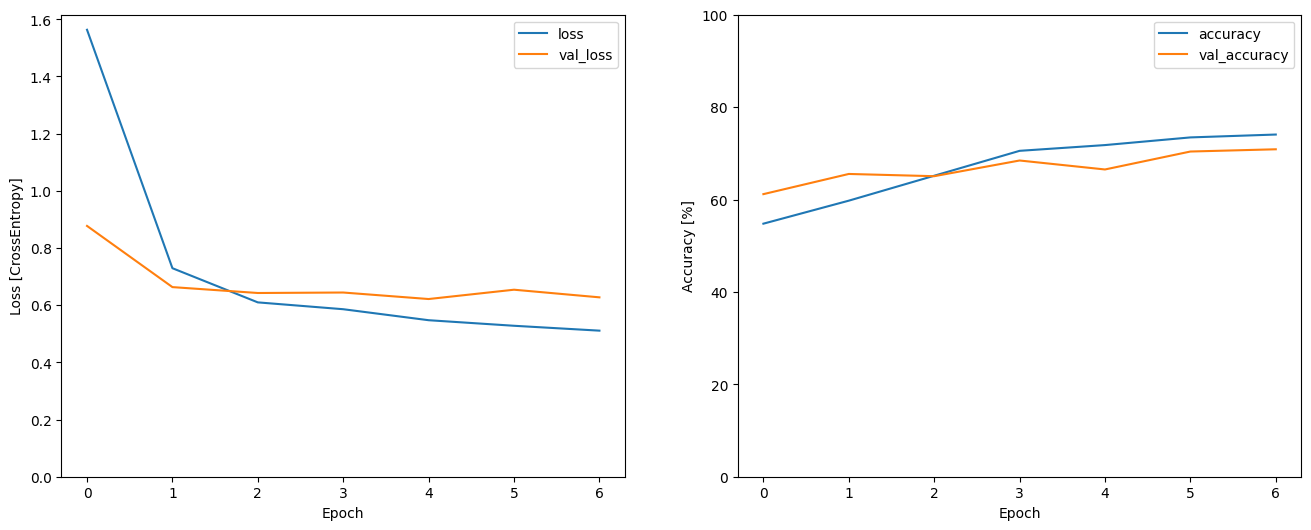

In [17]:
trained_history_spec_seq = trained_model_spec_seq.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds, 
    epochs=20,
    callbacks=callbacks
)
plot_history(trained_history_spec_seq)

### [Reinf] [Spec] Convolutional model

Epoch 1/20
31/31 [==============================] - 1s 13ms/step - loss: 5.9280 - accuracy: 0.4917 - val_loss: 4.0333 - val_accuracy: 0.5388
Epoch 2/20
31/31 [==============================] - 0s 7ms/step - loss: 2.6566 - accuracy: 0.5228 - val_loss: 1.3316 - val_accuracy: 0.6068
Epoch 3/20
31/31 [==============================] - 0s 10ms/step - loss: 1.3014 - accuracy: 0.5705 - val_loss: 1.0314 - val_accuracy: 0.5194
Epoch 4/20
31/31 [==============================] - 0s 9ms/step - loss: 1.1301 - accuracy: 0.5622 - val_loss: 1.0347 - val_accuracy: 0.5340
Epoch 5/20
31/31 [==============================] - 0s 6ms/step - loss: 1.1175 - accuracy: 0.5456 - val_loss: 1.0387 - val_accuracy: 0.5243
Epoch 6/20
31/31 [==============================] - 0s 6ms/step - loss: 1.1143 - accuracy: 0.5498 - val_loss: 1.0354 - val_accuracy: 0.5291


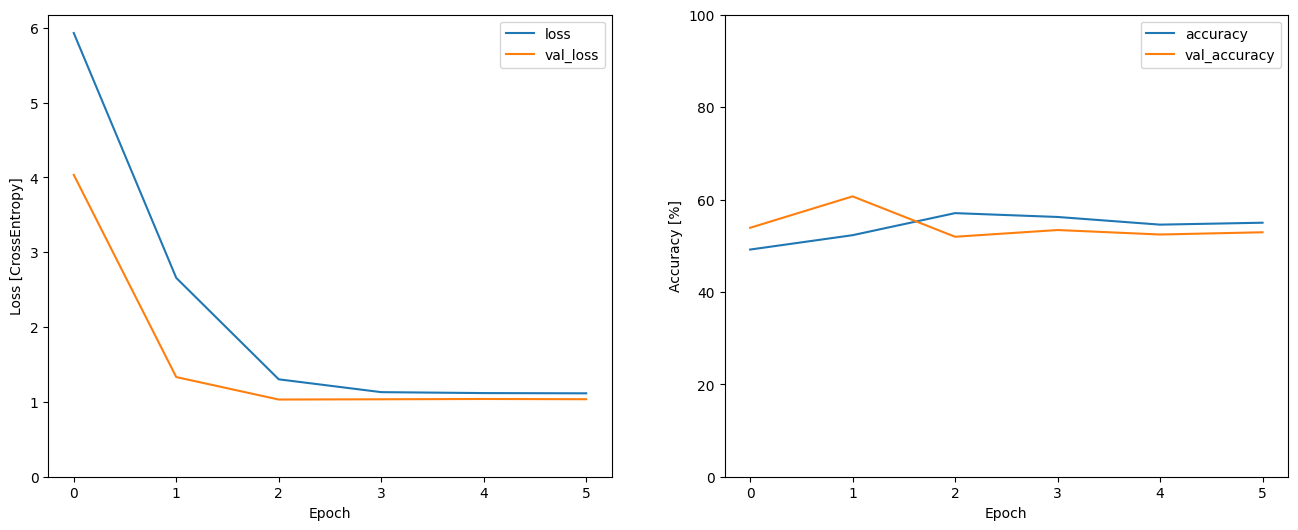

In [18]:
trained_history_spec_conv = trained_model_spec_conv.fit(
    train_spectrogram_ds, 
    validation_data=val_spectrogram_ds, 
    epochs=20,
    callbacks=callbacks
)
plot_history(trained_history_spec_conv)

# Save models

In [19]:
trained_model_mfcc_seq.save('models/renf_mfcc_seq.h5')
trained_model_mfcc_conv.save('models/renf_mfcc_conv.h5')
trained_model_spec_seq.save('models/renf_spec_seq.h5')
trained_model_spec_conv.save('models/renf_spec_conv.h5')

/Users/lantain/miniconda3/envs/tf/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Summary

In [20]:
def history_to_summary(prefix: str, history):
    print(f"{prefix}:    Loss: {history.history['loss'][-1]:.2f}, Acc: {history.history['accuracy'][-1]:.2f}, VLoss: {history.history['val_loss'][-1]:.2f}, VAcc: {history.history['val_accuracy'][-1]:.2f}" )

print("=== RAW ===")
history_to_summary("MFCCs + Seq       ", history_mfcc_seq)
history_to_summary("MFCCs + Conv      ", history_mfcc_conv)
history_to_summary("Spectrogram + Seq ", history_spec_seq)
history_to_summary("Spectrogram + Conv", history_spec_conv)
print("")
print("=== TRAINED ===")
history_to_summary("Tr. MFCCs + Seq       ", trained_history_mfcc_seq)
history_to_summary("Tr. MFCCs + Conv      ", trained_history_mfcc_conv)
history_to_summary("Tr. Spectrogram + Seq ", trained_history_spec_seq)
history_to_summary("Tr. Spectrogram + Conv", trained_history_spec_conv)


=== RAW ===
MFCCs + Seq       :    Loss: 0.32, Acc: 0.88, VLoss: 0.47, VAcc: 0.84
MFCCs + Conv      :    Loss: 0.57, Acc: 0.71, VLoss: 0.55, VAcc: 0.75
Spectrogram + Seq :    Loss: 0.54, Acc: 0.72, VLoss: 0.60, VAcc: 0.70
Spectrogram + Conv:    Loss: 0.55, Acc: 0.71, VLoss: 0.64, VAcc: 0.55

=== TRAINED ===
Tr. MFCCs + Seq       :    Loss: 0.32, Acc: 0.89, VLoss: 0.51, VAcc: 0.82
Tr. MFCCs + Conv      :    Loss: 0.59, Acc: 0.67, VLoss: 0.59, VAcc: 0.72
Tr. Spectrogram + Seq :    Loss: 0.51, Acc: 0.74, VLoss: 0.63, VAcc: 0.71
Tr. Spectrogram + Conv:    Loss: 1.11, Acc: 0.55, VLoss: 1.04, VAcc: 0.53
